# RNN 기초 예제 - MNIST 문제 해결 구현

In [1]:
!rm -fr logdir/mnist*
!mkdir -p logdir data/mnist

In [2]:
# coding: utf-8
%matplotlib inline
from __future__ import print_function, division
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/envs/tf36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.examples.tutorials.mnist.input_data \
    import read_data_sets

Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
mnist = read_data_sets('data/mnist', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
mnist.train.num_examples, \
mnist.train.images.shape, \
mnist.train.labels.shape

(55000, (55000, 784), (55000,))

In [6]:
mnist.test.num_examples, \
mnist.test.images.shape, \
mnist.test.labels.shape

(10000, (10000, 784), (10000,))

## 학습 데이터의 규격 설정

In [7]:
INPUT_UNITS = 28
NUM_HIDDEN_UNITS = 31

BATCH_SIZE = 128
MAX_SEQ_LEN = 28

## 훈련 루프 카운트 계산

In [8]:
train_loop_count = mnist.train.num_examples // BATCH_SIZE
test_loop_count  = mnist.test.num_examples // BATCH_SIZE

train_loop_count, test_loop_count

(429, 78)

## 훈련 루프 정의

In [9]:
def train(
    inputs,
    labels,
    max_epochs,
    train_writer=None,
    test_writer=None,
    mnist=mnist):
    
    step = 0
    for ep in range(max_epochs):

        train_elapsed = []
        train_losses = []
        train_accuracy = []
        for i in range(train_loop_count):
            t_start     = time.time()
            offs        = i * BATCH_SIZE
            batch_input = \
                mnist.train.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                        MAX_SEQ_LEN,
                                        INPUT_UNITS])
            batch_label = \
                mnist.train.labels[offs:offs+BATCH_SIZE]
            optimize, loss, accuracy, = \
                sess.run([model.optimize,
                          model.loss,
                          model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            train_elapsed.append(t_elapsed)

            step += 1

            if train_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='accuracy',
                            simple_value=accuracy
                        ),
                        tf.Summary.Value(
                            tag='loss',
                            simple_value=loss
                        ),
                    ]
                )
                train_writer.add_summary(summary,global_step=step)

            if step % 250 == 0:
                print(('[trn] ep {:d}, step {:d}, ' + 
                       'loss {:f}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.mean(train_losses),
                    np.amin(train_accuracy),
                    np.mean(train_elapsed)))
                train_losses = []
                train_accuracy = []
                train_elapsed = []

        test_elapsed  = []
        test_accuracy = []
        for i in range(test_loop_count):
            t_start     = time.time()
            offs        = i * BATCH_SIZE
            batch_input = \
                mnist.test.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                       MAX_SEQ_LEN,
                                       INPUT_UNITS])
            batch_label = \
                mnist.test.labels[offs:offs+BATCH_SIZE]
            accuracy, = \
                sess.run([model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            test_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            test_elapsed.append(t_elapsed)

            step += 1
            
            if test_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='accuracy',
                            simple_value=accuracy
                        ),
                    ]
                )
                test_writer.add_summary(summary,global_step=step)

            if step % 250 == 0:
                print(('[tst] ep {:d}, ' +
                       'step {:d}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.amin(test_accuracy),
                    np.mean(test_elapsed)))
                test_accuracy = []
                test_elapsed  = []


In [10]:
class MnistRnn:
    def __init__(self, 
                 inputs, 
                 labels, 
                 input_units, 
                 num_hidden_units, 
                 batch_size, 
                 max_seq_len):
        '''
        inputs: in shape [batch_size, max_seq_len, input_size]
        labels: in shape [batch_size]
        '''

        # ===>>> MultiRNNCell <<<===
        multi_cells     = tf.contrib.rnn.MultiRNNCell([
                            tf.contrib.rnn.BasicRNNCell(
                                num_hidden_units) \
                            for _ in \
                            range(3) ])

        sequence_length = [max_seq_len] * batch_size
        last, states    = tf.nn.dynamic_rnn(
                            multi_cells, 
                            inputs, 
                            sequence_length=sequence_length, 
                            dtype=tf.float32)
        
        # 여기서,
        # last.shape: [batch_size, max_seq_len, num_hidden_units]
        
        #####################################################
        # MultiRNNCell 을 쓰면 states값이 tensor 의 tuple 이 됨.
        # states.shape : ([?, num_hidden_units],...)
        #####################################################

        print('last.shape', last.get_shape().as_list())
        # print('states', states)

        # max_seq_len 축으로 0~27 까지 값 중에 
        # 0~26 때의 출력 값은 사용하지 않음
        rnn_output = last[:,max_seq_len-1,:] 
        # rnn_output shape: [batch_size, num_hidden_units]
        print('rnn_output.shape', rnn_output.get_shape().as_list())

        # 10 개의 output units 로 만들 
        # FCN (fully-connected-network) 구성
        # ==> shape: [batch_size, 10]
        outputs    = tf.layers.dense(rnn_output, 10)
        print('outputs.shape', outputs.get_shape().as_list())

        # loss 함수
        loss       = tf.losses.sparse_softmax_cross_entropy(
                        labels, outputs)
        optimize   = tf.train.AdamOptimizer(learning_rate=0.001). \
                        minimize(loss)

        # accuracy
        preds    = tf.argmax(outputs, axis=1)
        errors   = tf.count_nonzero(labels - preds)
        accuracy = 1.0 - tf.cast(errors,tf.float32) / \
                         tf.cast(tf.size(preds),tf.float32)

        # 클래스 객체 외부에서 참고할 수 있도록 속성으로 저장
        self.outputs        = outputs
        self.loss           = loss
        self.optimize       = optimize
        self.accuracy       = accuracy

## 텐서플로우 그래프 초기화, Placeholders 정의, 그래프 빌드

In [11]:
tf.reset_default_graph()

inputs_ = tf.placeholder( tf.float32, [BATCH_SIZE, MAX_SEQ_LEN, INPUT_UNITS], name='inputs')
labels_ = tf.placeholder( tf.int64, [BATCH_SIZE], name='labels')

model = MnistRnn(inputs_,
                 labels_,
                 INPUT_UNITS,
                 NUM_HIDDEN_UNITS,
                 BATCH_SIZE,
                 MAX_SEQ_LEN)

last.shape [128, 28, 31]
rnn_output.shape [128, 31]
outputs.shape [128, 10]


## 세션 초기화, 변수 초기화

In [12]:
config = tf.ConfigProto(gpu_options={'allow_growth':True})
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

In [15]:
train_writer = tf.summary.FileWriter( 'logdir/mnist-train', graph=tf.get_default_graph())
test_writer  = tf.summary.FileWriter( 'logdir/mnist-test', graph=tf.get_default_graph())

In [16]:
train(inputs_, labels_, 10, train_writer, test_writer, mnist=mnist)

[trn] ep 1, step 250, loss 0.715128, accu 0.632812, sec/iter 0.016920
[tst] ep 1, step 500, accu 0.742188, sec/iter 0.007012
[trn] ep 2, step 750, loss 0.399335, accu 0.726562, sec/iter 0.016575
[tst] ep 2, step 1000, accu 0.742188, sec/iter 0.006642
[trn] ep 3, step 1250, loss 0.299648, accu 0.789062, sec/iter 0.017275
[tst] ep 3, step 1500, accu 0.835938, sec/iter 0.006415
[trn] ep 4, step 1750, loss 0.244132, accu 0.796875, sec/iter 0.015857
[tst] ep 4, step 2000, accu 0.835938, sec/iter 0.006531
[trn] ep 5, step 2250, loss 0.219277, accu 0.851562, sec/iter 0.017299
[tst] ep 5, step 2500, accu 0.851562, sec/iter 0.007007
[trn] ep 6, step 2750, loss 0.188766, accu 0.859375, sec/iter 0.024874
[tst] ep 6, step 3000, accu 0.835938, sec/iter 0.006326
[trn] ep 7, step 3250, loss 0.172981, accu 0.867188, sec/iter 0.016492
[tst] ep 7, step 3500, accu 0.859375, sec/iter 0.006635
[trn] ep 8, step 3750, loss 0.157755, accu 0.851562, sec/iter 0.016017
[tst] ep 8, step 4000, accu 0.882812, sec/i

In [17]:
# !tensorboard --ip 0.0.0.0 --logdir ../logdir

In [18]:
import numpy as np

def mask_radial(shape, r, inv=False, center=True):
    h, w = shape

    mask = np.zeros(shape)

    if center:
        cx = w//2
        cy = h//2
    else:
        cx = 0
        cy = 0 # h-1

    for x in range(w):
        rx = abs(cx - x)
        ry = int(np.sqrt(r ** 2 - rx ** 2)) if rx < r else 0
        y1 = max(0, cy - ry)
        y2 = min(h, cy + ry)
        mask[y1:y2,x] = 1.0
            
    if inv:
        mask = 1 - mask

    return mask


def mask_random(shape, p, seed=80208700):
    h, w = shape
    np.random.seed(seed)
    mask = (np.random.uniform(size=shape) > p).astype(int)
    return mask


def apply_mask(image, mask):
    orig_dt = None
    if np.amax(image) > 1.1:
        orig_dt = image.dtype
        image = image / 255.0
    fft2 = np.fft.fftshift(np.fft.fft2(image[:,:]))
    fft2 *= mask
    # fix imaginary values
    image2 = np.real(np.fft.ifft2(np.fft.ifftshift(fft2[:,:])))
    # fix range
    image2 = np.minimum(1.0,np.maximum(0.0,image2))
    # fix dtype
    if orig_dt is not None:
        image2 = (image2 * 255).astype(orig_dt)
    return image2

## Perturbation

In [19]:
# MNIST 데이터 perturbation (mnist.train.images, mnist.test.images)

In [20]:
import copy
mnist2 = copy.deepcopy(mnist)

In [21]:
radius = 11.0
mask = mask_radial((28,28), radius)

In [22]:
import time
t_start = time.time()
for i, data in enumerate(mnist2.train.images):
    image = data.reshape([28,28])
    image2 = apply_mask(image,mask)
    mnist2.train.images[i,:] = image2.reshape([784])
t_elapsed = time.time() - t_start
print('elapsed',t_elapsed)

elapsed 9.608443975448608


NameError: name 'test_i' is not defined

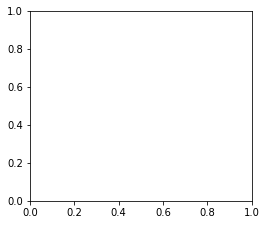

In [23]:
plt.figure(figsize=[13.5,3.5])
plt.subplot(131)
plt.imshow((mnist.train.images[test_i]).reshape([28,28]),cmap='gray',vmin=0.0,vmax=1.0)
plt.subplot(132)
plt.imshow((mnist2.train.images[test_i]).reshape([28,28]),cmap='gray',vmin=0.0,vmax=1.0)
plt.subplot(133)
plt.imshow((mnist.train.images[test_i]-mnist2.train.images[test_i]).reshape([28,28]),cmap='gray') #,vmin=0.0,vmax=1.0)

## 텐서플로우 그래프 초기화, Placeholders 정의, 그래프 빌드

In [ ]:
tf.reset_default_graph()

inputs_ = tf.placeholder( tf.float32, [BATCH_SIZE, MAX_SEQ_LEN, INPUT_UNITS], name='inputs')
labels_ = tf.placeholder( tf.int64, [BATCH_SIZE], name='labels')

model = MnistRnn(inputs_,
                 labels_,
                 INPUT_UNITS,
                 NUM_HIDDEN_UNITS,
                 BATCH_SIZE,
                 MAX_SEQ_LEN)

## 세션 초기화, 변수 초기화

In [ ]:
config = tf.ConfigProto(gpu_options={'allow_growth':True})
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

In [ ]:
train_writer2 = tf.summary.FileWriter( 'logdir/mnist2-train', graph=tf.get_default_graph())
test_writer2  = tf.summary.FileWriter( 'logdir/mnist2-test', graph=tf.get_default_graph())

In [ ]:
train(inputs_, labels_, 10, train_writer2, test_writer2, mnist=mnist2)

In [ ]:
!tensorboard --ip 0.0.0.0 --logdir ../logdir